In [1]:
import requests
import json
import pandas as pd
import numpy as np
from census import Census
from us import states
%matplotlib inline
census_API_key = "023709ad05870613b32186486d625cf41c6f2ac2"
variables = ('B19301_001E', 'B01003_001E', 'B23025_005E', 'B23025_002E')

c = Census(census_API_key)
testfips='120950170151' #170314201001
#x=c.acs5.state_county_blockgroup(variables, testfips[:2], testfips[2:5], "block group:{}".format(testfips[5:]))
acs_data_for_cook_county=c.acs5.get(variables, geo={'for': 'block group: *',
                       'in': 'state:17 county:031 tract: *'})
df_acs = pd.DataFrame(acs_data_for_cook_county)

acs_var_dict = {'B19013_001E' : "Income",
                'B19301_001E': "Income per capita",
                'B23025_002E': "Employment Labor force",
                'B23025_004E': "Employed",
                'B23025_005E' : "Unemployed",
                'B17001_002E' : "Poverty",
                'B01002_001E' : "Media Age",
                'B01003_001E' : "Population",
                'B02001_002E' : "White",
                'B02001_003E' : "Black",
                'B02001_005E' : "Asian",
                'B03001_003E' : "Hispanic Origin",
                'B25077_001E' : "Median Home Value"}

# These two were obtained with the downloader script in the data folder
buildings_df = pd.read_json("data/buildingsWithFIPS.json")
sanitation_df = pd.read_json("data/sanitation_df_with_fips.json")

In [2]:
df_x=df_acs.rename(columns={'block group':'block_group'}, inplace=False)
#df_x['FIPS']=df_acs.state.str.cat(df_acs.county,df_acs.block_group)
df_x['FIPS']=np.int64(df_x.state.str.cat(df_x.county.str.cat(df_x.tract.str.cat(df_x.block_group))))
df_x.set_index(['FIPS'], inplace=True)
df_y = buildings_df[['FIPS','service_request_number']].groupby('FIPS').count().rename(columns={'service_request_number':'vacant_building_calls'})
df_z = sanitation_df[['FIPS','service_request_number']].groupby('FIPS').count().rename(columns={'service_request_number':'sanitation_calls'})
df_analysis=df_y.join(df_z, how='outer').join(df_x)
df_analysis.sanitation_calls.fillna(0, inplace=True)
df_analysis.vacant_building_calls.fillna(0, inplace=True)
df_analysis.sort_values(by='sanitation_calls')
df_analysis.B19301_001E = pd.to_numeric(df_analysis.B19301_001E, errors='coerce')
df_analysis.B19301_001E.fillna(0,inplace=True)



## Income per capita and sanitation calls

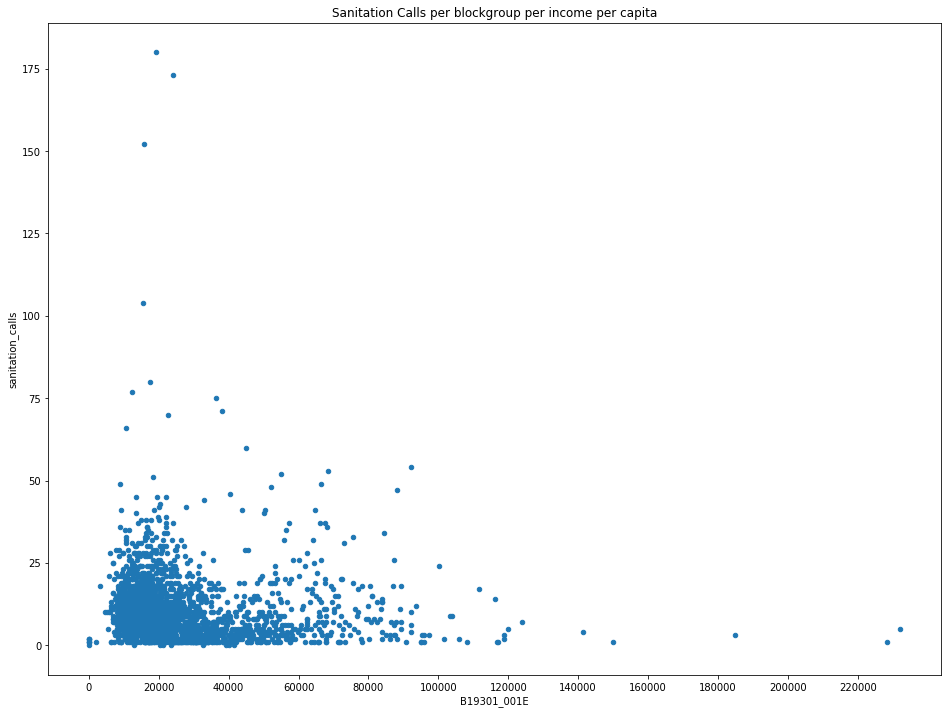

In [3]:
df_analysis.plot(y='sanitation_calls', x='B19301_001E',kind="scatter",figsize=(16, 12), xticks=(range(0,240000,20000)), title="Sanitation Calls per blockgroup per income per capita")

### We see that most calls are made by blocks with low income per capita

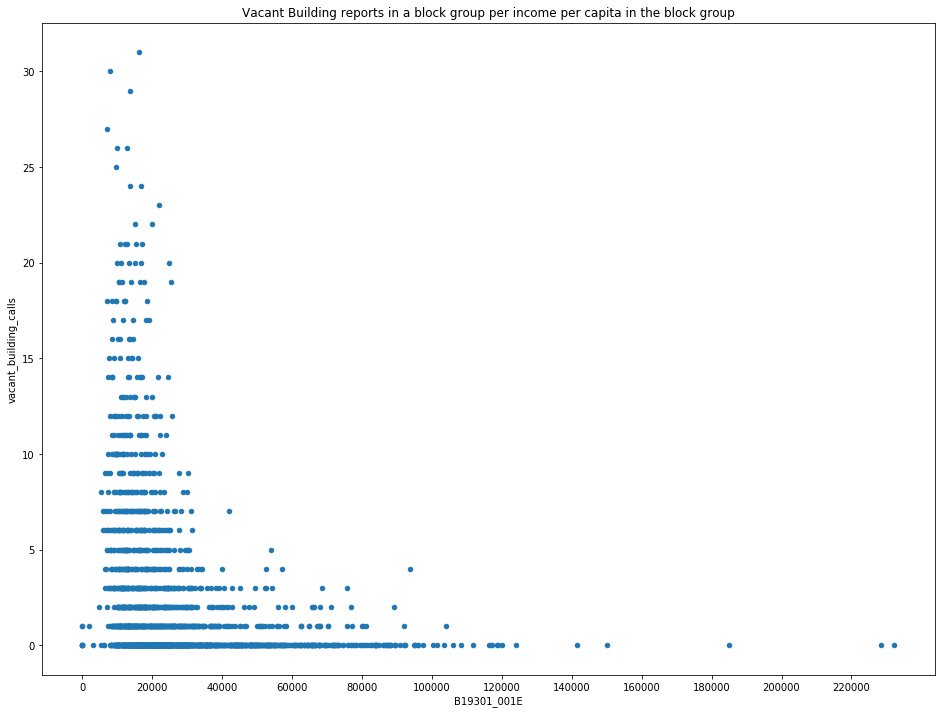

In [4]:
df_analysis.sort_values(by='vacant_building_calls')
df_analysis.plot(y='vacant_building_calls', x='B19301_001E',kind="scatter",figsize=(16, 12),  xticks=(range(0,240000,20000)),title="Vacant Building reports in a block group per income per capita in the block group")


### Likewise, We see that most vacant building calls are made by blocks with low income per capita, more dramatically than in the previous one


## Now we'll analyze unemployment share of the labor force in a block group

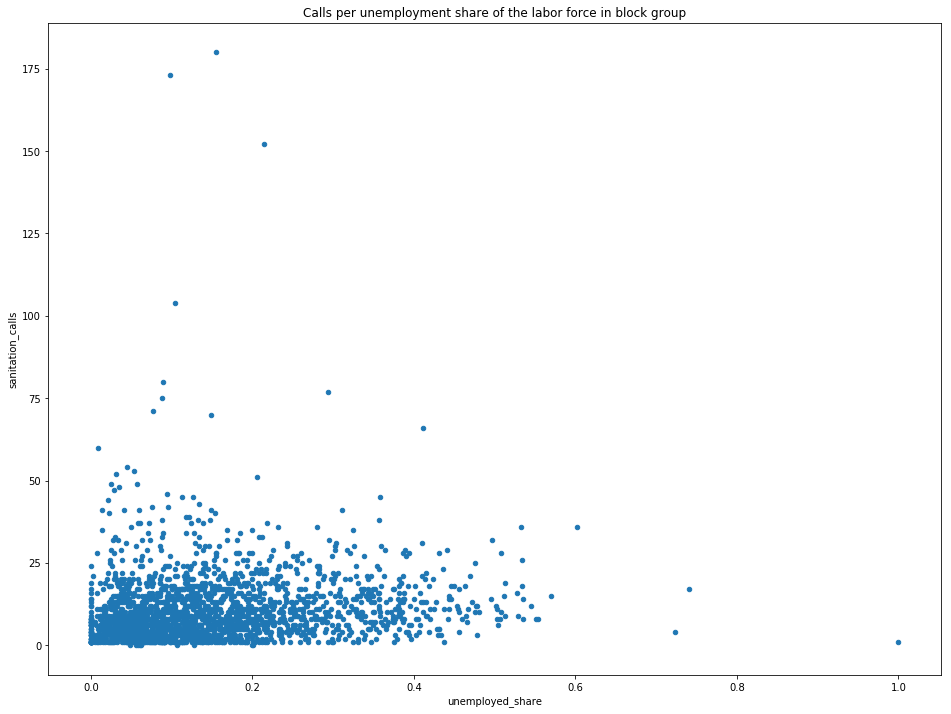

In [5]:
df_analysis.B23025_005E = pd.to_numeric(df_analysis.B23025_005E, errors='coerce')
#df_analysis.B19301_001E.fillna(0,inplace=True)
df_analysis.B23025_002E = pd.to_numeric(df_analysis.B23025_002E, errors='coerce')
#df_analysis.B19301_001E.fillna(0,inplace=True)
df_analysis["unemployed_share"] = df_analysis.B23025_005E/df_analysis.B23025_002E
df_analysis.plot(y='sanitation_calls', x='unemployed_share',kind="scatter",figsize=(16, 12), title="Calls per unemployment share of the labor force in block group")

### It's hard to tell what the correlation is in this case. It looks like the higher the unemployed share, more likely more calls are made

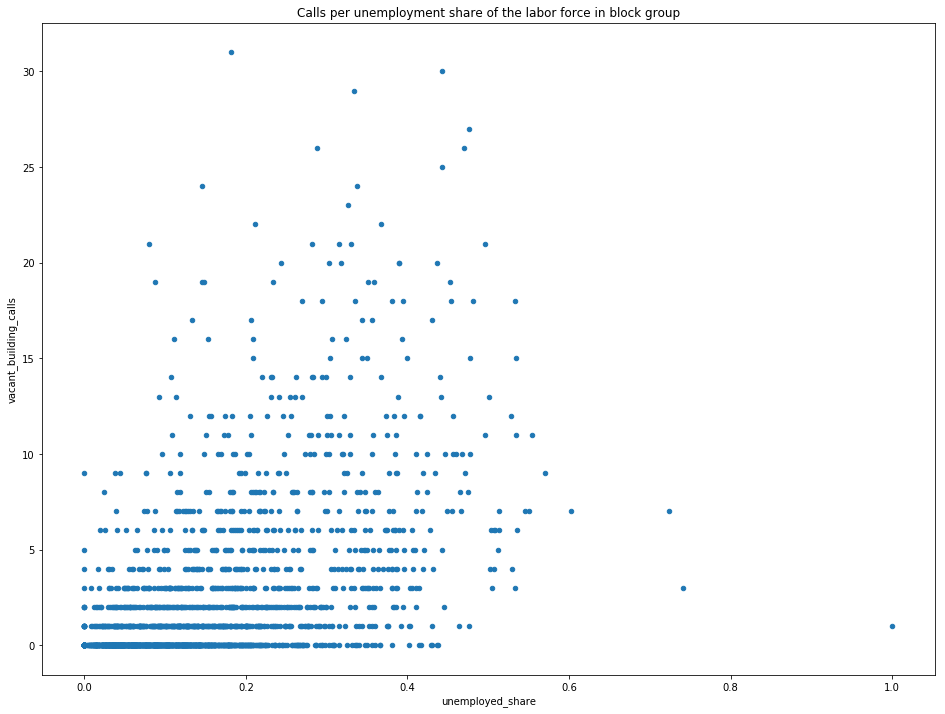

In [6]:
df_analysis.plot(y='vacant_building_calls', x='unemployed_share',kind="scatter",figsize=(16, 12), title="Calls per unemployment share of the labor force in block group")


### For vacant building calls, we see that the higher the share for unemployment in the block group, the higher call frequency